In [1]:
import geopandas as gpd
import pandas as pd
import eecisc
import seaborn
%matplotlib inline
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = (14, 7)

In [2]:
SOURCE_PATH = "/notebooks/sjoin_selection_arcgis.shp"
PROCESSED_PATH = "/notebooks/processed.shp"
ADJACENCY_PATH = "/notebooks/adjacency.csv"
source = eecisc.read_shapefile(SOURCE_PATH)
processed = eecisc.read_shapefile(PROCESSED_PATH)
adjacency = pd.read_csv(eecisc.read_file(ADJACENCY_PATH))

User name on eecisc: mmxc2
Password: ········
User name on eecisc: mmxc2
Password: ········
User name on eecisc: mmxc2
Password: ········


In [3]:
source_only_buildings = source[source.FTC == 1].copy()
source_only_buildings.sort_values(by='GTN', inplace=True)
source_only_buildings.reset_index(inplace=True)

In [4]:
assert source_only_buildings.index.size == processed.index.size
assert (source_only_buildings.GTN == processed.GTN).all()
assert source_only_buildings.geometry.intersects(processed.geometry).all()

# Case Study: Geopandas' Simplify vs ArcGIS

Objective: Determine whether Geopanda's Simplify can be used to replace ArcGIS

# 1. Discovering the best Tolerance Value

Geopandas' Simplify function only takes in one value - tolerance. Section 1 will be dedicated to the task of finding the tolerance value that will return the values closest to what ArcGIS returns.

Below are functions I have created for the convenience of analysis for this section. All functions introduced in each section are displayed at the top of the section.

In [5]:
def compare(tolerance):
    GP_tol = tolerance       #Set the tolerance for simplify
    Arc_change_mask = source_only_buildings.geometry != processed.geometry
    GP_change_mask = source_only_buildings.geometry != source_only_buildings.simplify(GP_tol).geometry
    Both_change_mask = [x and y for x, y in zip(Arc_change_mask, GP_change_mask)]
    Different_change_mask = source_only_buildings[Both_change_mask].simplify(GP_tol).geometry != processed[Both_change_mask].geometry
    Either_changed_mask = [x or y for x,y in zip(Arc_change_mask, GP_change_mask)]
    
    building_data ={'ArcGIS': Arc_change_mask,                #Returns True if ArcGIS changes source buildings
                   'Geopandas': GP_change_mask,                #Returns True if GP Simplify changes source buildings
                   'Both': Both_change_mask,                  #Returns True if both GP and ArcGIS made changes to same building
                   'Different change': Different_change_mask,  #Returns True if the changes by GP and ArcGIS are different
                   'Either': Either_changed_mask}           #Returns True if changed by EITHER GP or ArcGIS

    building_df = pd.DataFrame(building_data, columns = ['ArcGIS', 'Geopandas', 'Both', 'Different change', 'Either'])
    return building_df

In [6]:

def min_vals(data_frame):
    for column in data_frame.columns:
        print(column, min(abs(data_frame[column])), sep=': \n', end='\n\n')

In [7]:
def filter_data(data_frame, variable, limit, limit2=0):
    min_mask = abs(data_frame[variable]) <= limit
    max_mask = abs(data_frame[variable]) >= limit2
    mask = [x and y for x,y in zip(min_mask, max_mask)]
    #mask.fillna(False)
    return data_frame[mask]

In [8]:
def best_tolerance(comparison, typ, minimum):
    if minimum:
        minormax = (min(comparison[typ].values))
        print (minormax)
    elif minimum == False:
        minormax = (max(comparison[typ].values))
        print (minormax)
    else: 
        print ('Error')
    for i in comparison[typ].index:
        if minormax == comparison[typ][i]:
            print(i, end='  ')
    print ('\n')

# 1.1 Smallest Number of Geometric Differences

Below are my attempts to find the tolerance value that would minimise the difference in number of geometrically different buildings between ArcGIS and Geopandas' Simplify

In [9]:
comparison_data = {'Geopandas': [],
                   'Both': [],
                   'Different': [],
                   'Either':[]
                  }
test_range1 = [x/100 for x in range(1,50)]

for i in test_range1:
    comparison_data['Geopandas'].append(compare(i)['Geopandas'].sum())
    comparison_data['Both'].append(compare(i)['Both'].sum())
    comparison_data['Different'].append(compare(i)['Different change'].sum())
    comparison_data['Either'].append(compare(i)['Either'].sum())
    

In [10]:
ngd_comparison = pd.DataFrame(comparison_data, index = test_range1)

In [11]:
ngd_comparison

,Both,Different,Either,Geopandas
0.01,69,41,199,188
0.02,71,42,199,190
0.03,74,45,200,194
0.04,74,44,200,194
0.05,76,46,201,197
0.06,76,46,201,197
0.07,77,47,202,199
0.08,77,47,202,199
0.09,78,47,202,200
0.10,78,47,202,200


Table 1.1.1 Number of Buildings that are Geometrically Different between ArcGIS and GP altered buildings based on Tolerances

In [12]:
best_tolerance(ngd_comparison, 'Geopandas', True)   
#Prints out minimum number of buildings changed by Geopandas' simplify and the range of tolerance required

best_tolerance(ngd_comparison, 'Both', False)       
#Prints out maximum number of buildings changed by BOTH Geopandas and ArcGIS and the range of tolerance required

best_tolerance(ngd_comparison, 'Different', True)  
#Prints out the minimum number of buildings with different changes due to GP and Arc.


188
0.01  

80
0.39  0.4  0.41  0.42  0.43  0.44  0.45  0.46  0.47  0.48  0.49  

41
0.01  



As can be seen from the above data, it is nearly impossible to reduce the number of buildings changed by GP Simplify to 80 (which is the number affected by ArcGIS) without reducing the tolerance to very low levels.

It is obvious that Geopandas' Simplified is much more aggressive than ArcGIS in altering buildings. We thus need to consider how large the effect of these alterations are (section 2)

Of these 80 buildings, based on the data above, the tolerance which gives us the minimum difference between the GP-Simplified and ArcGIS altered buildings will be in the range of 0.4-0.43, giving us 38 similar buildings. 

However, the range of 0.4-0.43 is only marginally better than the rest. Going to lower tolerances also reduces the number of total altered buildings so the range of 0.32-0.38 may be a better option. 

### 1.1a Exception Case Building 85

When tolerance > 0.38, there are NO ArcGIS processed buildings that are not altered by Geopandas Simplify. 80 out of the 80 ArcGIS buildings are altered by Geopandas

When tolerance <= 0.38, there is one building that ArcGIS has altered that Geopandas did not.

In [13]:
exception = compare(0.38)
for x in exception.index:
    if exception['Geopandas'][x]==False and exception['ArcGIS'][x]==True:
        print (x)
    

85


In [14]:
building85 = source_only_buildings.ix[85]
processed_building85 = processed.ix[85]

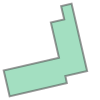

In [15]:
building85.geometry

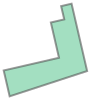

In [16]:
processed_building85.geometry

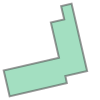

In [17]:
building85.geometry.simplify(0.38)

Figures 1.1.2a. Building 85's Raw Plot
        1.1.2b. Building 85's ArcGIS altered Plot
        1.1.2c. Building 85's Geopandas' altered plot

In [18]:
area_difference = processed.area[85]-source_only_buildings.simplify(0.38).area[85]
area_difference

-0.70839999702610079

In [19]:
pv85 =  processed.geometry.map(lambda x: len(x.exterior.coords))[85]
sv85 = source_only_buildings.simplify(0.34).geometry.map(lambda x: len(x.exterior.coords))[85]
sv85-pv85

2

The ArcGIS area has decreased and two vertices are removed. Not sure why this has happened for ArcGIS but not for Geopanda. May need to check the surrounding buildings to check the effect of this change by ArcGIS. 

### Update

*** Originally, the goal of this study was to determine the geopanda tolerance that led to most similar result with ArcGIS. After some discussion of results already collected, there may be a shift in focus from trying to copy ArcGIS with Geopandas to trying to achieve ArcGIS' main goal with Geopandas instead.

As far as I know, the main objective of ArcGIS' Simplify tool is to reduce the number of vertices while trying to minimise area differences between the altered buildings and the source buildings.

If that is the objective of ArcGIS, then it is possible to achieve that objective even better with Geopandas. In Section 1.3 I will compare the differences between the Source buildings and Geopandas' buildings. This way, it may be possible to find a tolerance value for Geopandas' that provides simplified polygons with much reduced vertices while retaining the same area - therefore, doing a better job than ArcGIS.

# 1.2 Comparing Differences in Area and Vertices

In [20]:
#Using comparison_data from above
#Sum up the absolute sum of the difference in area between ArcGIS and GP Simplify altered buildings:

compare_adv = {'GP/Arc Abs Ar Diff': [],
               'GP/Arc Ar Diff': [],
               'GP/Arc Abs Ver': [],
               'GP/Arc Vertices': []}

test_range = [i/100 for i in range(1, 50)]

for i in test_range:
    mask = compare(i).fillna(False)['Either']
    abs_sum_diff = abs(source_only_buildings[mask].simplify(i).area - processed[mask].area).sum()
    sum_diff = (source_only_buildings[mask].simplify(i).area - processed[mask].area).sum()
    s_ver = (source_only_buildings[mask].simplify(i).geometry.map(lambda x: len(x.exterior.coords)))
    p_ver = (processed[mask].geometry.map(lambda x: len(x.exterior.coords)))
    abs_diff_ver = (sum([abs(x-y) for x,y in zip(s_ver.tolist(), p_ver.tolist())]))
    diff_ver = (sum([(x-y) for x,y in zip(s_ver.tolist(), p_ver.tolist())]))
    
    compare_adv['GP/Arc Abs Ar Diff'].append(abs_sum_diff)
    compare_adv['GP/Arc Ar Diff'].append(sum_diff)
    compare_adv['GP/Arc Abs Ver'].append(abs_diff_ver)
    compare_adv['GP/Arc Vertices'].append(diff_ver)
    
adv_comparison = pd.DataFrame(compare_adv, columns = [i for i in compare_adv.keys()], index=test_range)

In [21]:
#adv_comparison  #Uncomment to view the full table

Table 1.2.1 GP vs ArcGIS differences in (Absolute) Area and comparison of (Absolute) Vertices

In [22]:
min_vals(adv_comparison) # Minimum values for each column in adv_comparison

GP/Arc Abs Ver: 
293

GP/Arc Abs Ar Diff: 
16.8760499584

GP/Arc Vertices: 
122

GP/Arc Ar Diff: 
0.323300021203



In [23]:
print(min(adv_comparison['GP/Arc Abs Ar Diff']))
print(min(abs(adv_comparison['GP/Arc Ar Diff'])))
print(min(adv_comparison['GP/Arc Abs Ver']))
print(min(abs(adv_comparison['GP/Arc Vertices'])))

16.8760499584
0.323300021203
293
122


In [24]:
filter_data(adv_comparison, 'GP/Arc Abs Ar Diff', 20)

,GP/Arc Abs Ver,GP/Arc Abs Ar Diff,GP/Arc Vertices,GP/Arc Ar Diff
0.26,299,17.79035,-269,4.56555
0.27,299,17.79035,-269,4.56555
0.28,300,19.19445,-270,3.16145
0.32,297,18.04890,-277,0.32330
0.33,297,18.04890,-277,0.32330
0.34,298,17.36330,-280,-0.39240
0.36,298,19.80025,-286,-3.57365
0.37,299,19.29545,-287,-4.07845
0.38,299,19.29545,-287,-4.07845
0.39,298,18.51565,-292,-4.85825


Table 1.2.2 [Table 1.2.1] filtered for magnitude of GP/ArcGIS Absolute Area Difference below 20 

In [25]:
a=source_only_buildings.area.sum()
b=processed.area.sum()
c=abs(source_only_buildings.area - processed.area).sum()
#d=(source_only_buildings.simplify(0.32).area - source_only_buildings.area).sum()

print (a, b, a-b, ' ', c, sep='\n')
#Area of source buildings
#Area of ArcGIS processed buildings
#Difference between source and ArcGIS processed buildings

#Absolute Difference between Raw and ArcGIS buildings

30261.2821501
30248.7020501
12.5801000192
 
20.8476000122


Geopandas has an obviously stronger effect than ArcGIS in reducing the number of Vertices. *This is not necessarily bad

As can be seen above, it is possible to reduce the sum of the area differences to very low levels 

However, it could be that the absolute area difference gives a better indicator of the number of discrepancies in geometry between ArcGIS processed and Geopanda Simplified buildings. In order to understand the significance of this variable, we compare ArcGIS and Geopandas absolute area difference with Source Buildings themselves in Section 1.3

# 1.3 Comparison of effect of ArcGIS vs Geopandas on Source Buildings

In [26]:
def add_column(df, array, column_name):
    if len(array) == len(df.index):
        series = pd.Series(array, index=df.index)
        df[column_name] = series
        return df
    else:
        print('Not correct length')

In [27]:
test_range = adv_comparison.index

raw_abs_ad = []
raw_sum_ad = []
raw_abs_ver = []
raw_ver = []

for i in test_range:
    mask = compare(i).fillna(False)['Either']
    abs_ad = abs(source_only_buildings[mask].simplify(i).area - source_only_buildings[mask].area).sum()
    sum_ad = (source_only_buildings[mask].simplify(i).area - source_only_buildings[mask].area).sum()
    s_ver = (source_only_buildings[mask].simplify(i).geometry.map(lambda x: len(x.exterior.coords)))
    r_ver = (source_only_buildings[mask].geometry.map(lambda x: len(x.exterior.coords)))
    abs_diff_ver = (sum([abs(x-y) for x,y in zip(s_ver.tolist(), r_ver.tolist())]))
    diff_ver = (sum([(x-y) for x,y in zip(s_ver.tolist(), r_ver.tolist())]))
    raw_abs_ad.append(abs_ad)
    raw_sum_ad.append(sum_ad)
    
    raw_abs_ver.append(abs_diff_ver)
    raw_ver.append(diff_ver)

In [28]:
adv2_data = {'Raw/GP Abs Ar Diff': raw_abs_ad,
            'Raw/GP Ar Diff': raw_sum_ad,
            'Raw/GP Abs Ver': raw_abs_ver,
            'Raw/GP Ver': raw_ver}
adv2_comparison = pd.DataFrame(adv2_data, index=test_range)

In [29]:
#Uncomment for table with all values of Raw vs GP Area and Vertices Comparisons
#adv2_comparison

Table 1.3.1 Comparison of (Absolute) Area Difference and (Absolute) Vertices between Raw and Geopandas' altered buildings

In [30]:
#print(min(adv_comparison['Raw/GP Abs Ar Diff']))
#print(min(abs(adv_comparison['Raw/GP Ar Diff'])))
full_comparison = pd.concat([adv_comparison, adv2_comparison, ngd_comparison], axis=1)

In [31]:
#Uncomment and run to have full table of analysis
#full_comparison

Table 1.3.2 Table with values for all comparisons (combination of tables [1.1.1], [1.2.1] and [1.3.1])

In [32]:
#filter_data (full_comparison, 'Raw/GP Ar Diff', 17)

In [33]:
#Minimum Values for each column in full comparison
min_vals(full_comparison)

GP/Arc Abs Ver: 
293

GP/Arc Abs Ar Diff: 
16.8760499584

GP/Arc Vertices: 
122

GP/Arc Ar Diff: 
0.323300021203

Raw/GP Abs Ar Diff: 
3.5595999827

Raw/GP Abs Ver: 
358

Raw/GP Ar Diff: 
0.0141500124945

Raw/GP Ver: 
358

Both: 
69

Different: 
41

Either: 
199

Geopandas: 
188



In [34]:
a=source_only_buildings.area.sum()
b=processed.area.sum()
c=abs(source_only_buildings.area - processed.area).sum()
d=(source_only_buildings.simplify(0.32).area - source_only_buildings.area).sum()

print (a, b, b-a, ' ', c, d, sep='\n')
#Area of source buildings
#Area of ArcGIS processed buildings
#Difference between source and ArcGIS processed buildings

#Absolute Difference between Raw and ArcGIS buildings
#Simplified - Raw area

30261.2821501
30248.7020501
-12.5801000192
 
20.8476000122
-12.256799998


In [35]:
filter_data (full_comparison, 'GP/Arc Abs Ar Diff', 20, 0)

,GP/Arc Abs Ver,GP/Arc Abs Ar Diff,GP/Arc Vertices,GP/Arc Ar Diff,Raw/GP Abs Ar Diff,Raw/GP Abs Ver,Raw/GP Ar Diff,Raw/GP Ver,Both,Different,Either,Geopandas
0.26,299,17.79035,-269,4.56555,22.03265,505,-8.01455,-505,79,44,202,201
0.27,299,17.79035,-269,4.56555,22.03265,505,-8.01455,-505,79,44,202,201
0.28,300,19.19445,-270,3.16145,23.43675,506,-9.41865,-506,79,44,203,202
0.32,297,18.04890,-277,0.32330,28.13000,513,-12.25680,-513,79,44,203,202
0.33,297,18.04890,-277,0.32330,28.13000,513,-12.25680,-513,79,44,203,202
0.34,298,17.36330,-280,-0.39240,28.28640,516,-12.97250,-516,79,44,203,202
0.36,298,19.80025,-286,-3.57365,31.46765,522,-16.15375,-522,79,44,203,202
0.37,299,19.29545,-287,-4.07845,31.97245,523,-16.65855,-523,79,44,203,202
0.38,299,19.29545,-287,-4.07845,31.97245,523,-16.65855,-523,79,44,203,202
0.39,298,18.51565,-292,-4.85825,33.33765,528,-17.43835,-528,80,43,204,204


Table 1.3.3 Filtered Table [1.3.2] based on Absolute Area Difference between GP and ArcGIS altered buildings

In [36]:
#You may play around with filtering the data. 
filter_data (full_comparison, 'Raw/GP Abs Ar Diff', 24, 0)

,GP/Arc Abs Ver,GP/Arc Abs Ar Diff,GP/Arc Vertices,GP/Arc Ar Diff,Raw/GP Abs Ar Diff,Raw/GP Abs Ver,Raw/GP Ar Diff,Raw/GP Ver,Both,Different,Either,Geopandas
0.01,388,22.13900,-122,12.11220,3.55960,358,-0.46790,-358,69,41,199,188
0.02,386,21.98030,-132,12.01550,3.81880,368,-0.56460,-368,71,42,199,190
0.03,366,22.57120,-158,12.24230,4.66810,394,-0.33780,-394,74,45,200,194
0.04,348,22.51805,-178,12.59425,5.42695,414,0.01415,-414,74,44,200,194
0.05,342,23.34925,-190,13.52545,6.87535,426,0.94535,-426,76,46,201,197
0.06,340,24.13665,-194,12.65445,7.81435,430,0.07435,-430,76,46,201,197
0.07,335,24.73800,-201,11.84940,8.74470,437,-0.73070,-437,77,47,202,199
0.08,332,24.58685,-204,11.81235,8.78175,440,-0.76775,-440,77,47,202,199
0.09,319,22.79820,-217,12.14950,10.26680,453,-0.43060,-453,78,47,202,200
0.10,317,24.53195,-225,12.94445,12.45965,461,0.36435,-461,78,47,202,200


Table 1.3.4 Filtered Table [1.3.2] based on Absolute Area Difference between GP and Raw buildings

Based on the above data, it is difficult to come to a clear answer for which is the best tolerance. Thus, I have come up with 2 answers based on 2 criteria.

1. For the tolerance that gives the closest immitation of the ArcGIS simplifying function, 0.4 would be the best value as it has the smallest absolute area difference between Geopandas and ArcGIS.

2. However, for the purpose of reducing maximum number of vertices while minimally changing the area, I'm strongly inclined to go with much lower tolerances ie range of 0.10-0.12, or possibly even lower as these give minimal changes while doing a good job of removing lots of vertices. I would pick 0.12.


Due to the difficulty in selecting a tolerance from the above analysis on area and vertices, 

# Section 2 Discovering where the Discrepancies Are

In [37]:
def plot_building(number, tolerance=0.4):
    building = source_only_buildings.ix[number].geometry
    building_processed = processed.ix[number].geometry
    building_simplified = source_only_buildings.ix[number].geometry.simplify(tolerance)
    ax=gpd.GeoSeries([building]).plot(label='original', figsize=(7, 9))
    gpd.GeoSeries([building_processed]).plot(ax=ax, linestyle='--', label='ArcGIS')
    gpd.GeoSeries([building_simplified]).plot(ax=ax, linestyle='-.', label='Shapely')
    plt.title('Building #%d'%number)
    legend = plt.legend()

In [38]:
from collections import OrderedDict
def compare_values(number, dataframe=pd.DataFrame(index=[], columns = []), tolerance = 0.4, answer=None):
    
    a = source_only_buildings.area[number]
    b = source_only_buildings.simplify(tolerance).area[number]
    c = processed.area[number]
    d = source_only_buildings.geometry.map(lambda x: len(x.exterior.coords))[number]
    e = source_only_buildings.simplify(tolerance).geometry.map(lambda x: len(x.exterior.coords))[number]
    f = processed.geometry.map(lambda x: len(x.exterior.coords))[number]
    para = [a,b,c,d,e,f]
    
    values = OrderedDict()
    values['Raw Area'] = a
    values['GP Area'] = b
    values['ArcGIS Area'] = c
    values['Raw Vertices'] = int(d)
    values['GP Vertices'] = int(e)
    values['ArcGIS Vertices'] = int(f)
    
    if type(dataframe) is not pd.DataFrame:
        dataframe =pd.DataFrame(index=[], columns = [])
        #print('Something')
    
    if dataframe.empty:
        dataframe = pd.DataFrame(values, columns = [i for i in values], index = [number])
        return dataframe
    
    elif len(dataframe.columns)!=len(para):
        print('Invalid empty dataframe. Replaced with new dataframe')
        dataframe = pd.DataFrame(values, columns = [i for i in values], index = [number])
        return dataframe
    
    elif len(dataframe.index)!=0:
        if answer==None:
            answer = input('Replace data?[y/n]')
        while answer != 'y' or answer != 'n':
            if answer == 'y':
                dataframe = pd.DataFrame(values, columns = [i for i in values], index = [number])
                return dataframe
            elif answer == 'n':
                dataframe.loc[number] = para
                return dataframe
            else:
                answer=input('Invalid input. Replace data?[y/n]')
    
    else:
        dataframe.loc[number] = para
        return dataframe
    

## Reference 2

For reference, some of the values from the ArcGIS processed buildings are presented below:

In [39]:
a=source_only_buildings.area.sum()
b=processed.area.sum()
c=abs(source_only_buildings.area - processed.area).sum()

print (a, b, a-b, ' ', c, sep='\n')
#Area of source buildings
#Area of ArcGIS processed buildings
#Difference between source and ArcGIS processed buildings

#Absolute Difference between Raw and ArcGIS buildings


30261.2821501
30248.7020501
12.5801000192
 
20.8476000122


In [40]:
d=source_only_buildings.geometry.map(lambda x: len(x.exterior.coords)).sum()
e=processed.geometry.map(lambda x: len(x.exterior.coords)).sum()
print (d, e, d-e, sep='\n')

#Raw Vertices
#ArcGIS Vertices
#Raw-ArcGis Vertices

2919
2683
236


# 2.1 GP vs ArcGIS differences compared to Raw (Tolerance = 0.4)

We shall first use a tolerance of 0.4 to test out the differences in GP-Simplified and ArcGIS altered buildings. 

There are 2 variables of particular interest - area and wall orientations. 

We shall first try to sort the buildings with the greatest

In [41]:
test_tol = 0.4

#Code is not elegant here but it is simply extracting the index of the altered buildings that are not similar
#i.e. index of buildings in the 'Different change' column

Different_mask = compare(test_tol)['Different change']

int_list = [i for i, x in enumerate(Different_mask) if x==True]
int_list_index = [i for i in Different_mask.index]

dbuildings = []
for i in int_list:
    dbuildings.append(int_list_index[i])
    
difference_in_area = []
for i in dbuildings:
    difference_in_area.append((source_only_buildings.simplify(test_tol).area[i]-processed.area[i]))

dbuilding_data = {'index': dbuildings,
                 'Area Difference': difference_in_area}

db_df = pd.DataFrame(difference_in_area, columns=['Area Difference'], index = dbuildings)

db_df.sort_values(by='Area Difference', ascending=False)

,Area Difference
67,7.395000e-01
188,5.339000e-01
224,4.573500e-01
13,2.767500e-01
148,4.540001e-02
125,3.970000e-02
173,2.560000e-02
169,2.375001e-02
150,1.630001e-02
186,1.625000e-02


Table 2.1.1 Table of area difference between all different ArcGIS and GP (tolerance = 0.4) altered buildings, sorted in descending order

From this data, we shall visually examine the differences in effect of ArcGIS vs GP on Raw buildings.

We shall consider the following buildings:
    Building # 67, 188, 80, 229, 215, 6, 369

In [42]:
Test_buildings = [67,188,215,80,229,6,369]

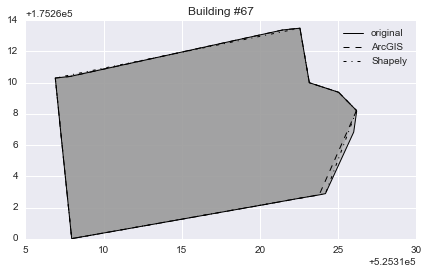

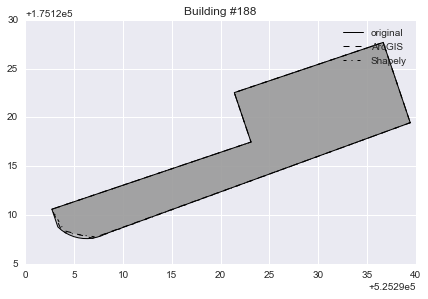

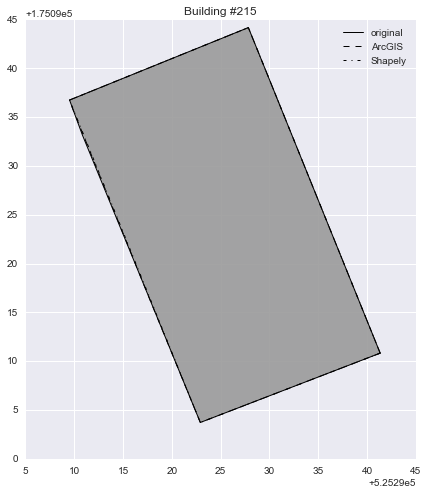

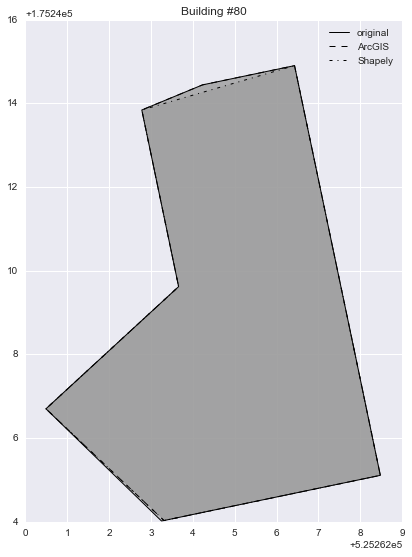

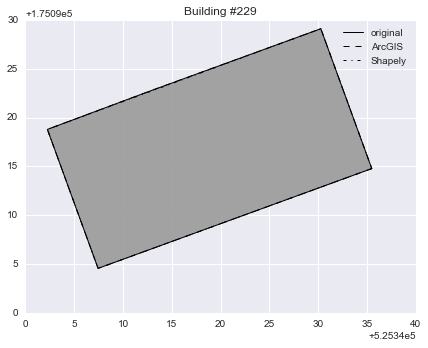

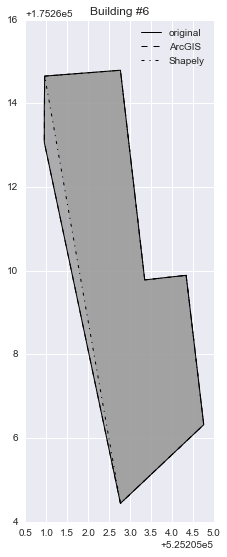

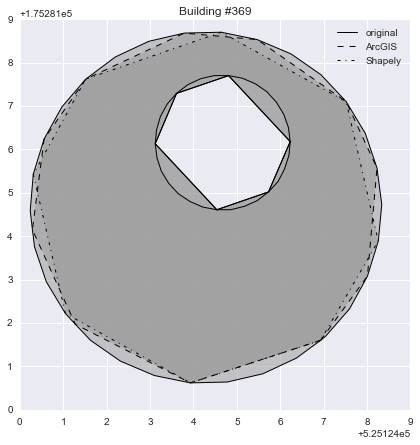

In [43]:
for i in Test_buildings:
    plot_building(i, test_tol)

Figures 2.1.1 Plots of Raw/GP/ArcGIS test buildings 67, 188, 80, 229, 215, 6, 369

In [44]:
analyse_test_buildings = []
for number in Test_buildings:
    analyse_test_buildings = compare_values(number, analyse_test_buildings, test_tol, answer='n')

In [45]:
analyse_test_buildings

,Raw Area,GP Area,ArcGIS Area,Raw Vertices,GP Vertices,ArcGIS Vertices
67,182.53500,181.38530,180.64580,18.0,8.0,15.0
188,226.12025,225.34220,224.80830,22.0,8.0,11.0
215,709.26060,706.96140,708.34090,8.0,5.0,7.0
80,50.17840,49.76100,50.08420,11.0,8.0,10.0
229,454.21175,453.34345,454.21325,9.0,5.0,8.0
6,20.41170,18.92660,20.40755,9.0,7.0,8.0
369,43.62765,40.29035,42.27965,34.0,9.0,12.0


Table 2.1.2 Raw/GP/ArcGIS Areas and Vertices for each test buildings

Both GP and ArcGIS are very aggressive in reducing vertices when there are curves. (See building 67, 188 and 369)

Despite the somewhat significant difference in area change, buildings 215 and 229 seem to follow ArcGIS changes reasonably well. The only issue will be whether these changes affect connections with neighbouring buildings***

Building 6, 80, 188 and 369 have more significant changes. Building 369 and the curve of building 188 would be difficult to simplify regardless of how the tolerance is manipulated. 

However, building 6, 67 and 80 deviate very obviously from ArcGIS' changes when it cuts out the extra vertices. 

This leads me to conclude that using lower tolerances to avoid such obvious visual alterations would be the way to go.

## Conclusion of 2.1:
Tolerance = 0.4 rejected due to the significant change in wall orientation caused by Geopandas' change

# 2.2 ArcGIS/Geopandas vs Raw Buildings (Tolerance = 0.12)

In [46]:
test_tol = 0.12

#Code is not elegant here but it is simply extracting the index of the altered buildings that are not similar
#i.e. index of buildings in the 'Different change' column

Different_mask = compare(test_tol)['Different change']

int_list = [i for i, x in enumerate(Different_mask) if x==True]
int_list_index = [i for i in Different_mask.index]

dbuildings = []
for i in int_list:
    dbuildings.append(int_list_index[i])
    
difference_in_area = []
for i in dbuildings:
    difference_in_area.append((source_only_buildings.simplify(test_tol).area[i]-processed.area[i]))

dbuilding_data = {'index': dbuildings,
                 'Area Difference': difference_in_area}

db2_df = pd.DataFrame(difference_in_area, columns=['Area Difference'], index = dbuildings)

db2_df.sort_values(by='Area Difference', ascending=False)

,Area Difference
67,1.633800e+00
188,1.591600e+00
55,1.329750e+00
129,1.040350e+00
36,9.384500e-01
44,9.341500e-01
215,8.935500e-01
275,8.257500e-01
101,7.422500e-01
369,5.393500e-01


Table 2.2.1 Table of area difference between all different ArcGIS and GP (tolerance = 0.12) altered buildings, sorted in descending order 

There already is a noticeable difference when using tolerance = 0.12 in that GP altered buildings have larger areas than ArcGIS buildings. In order to understand why, the buildings with the greatest area changes are analysed again.

This time, buildings 67, 188, 55 and 129, with 229 and 60 are tested alongside building 6, 80 and 369 from the previous tests

In [47]:
Test_buildings_2 = [6, 55, 60, 67, 80, 129, 188, 229, 369]

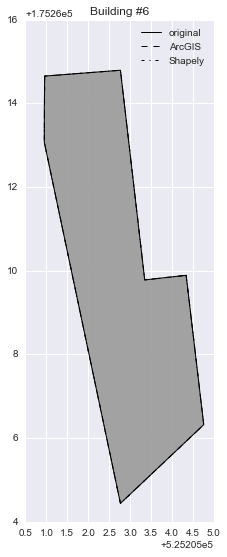

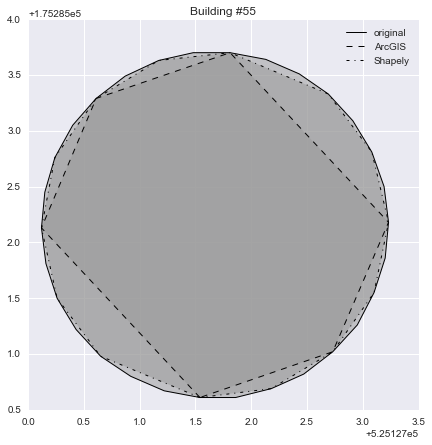

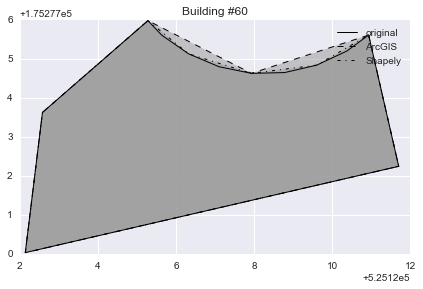

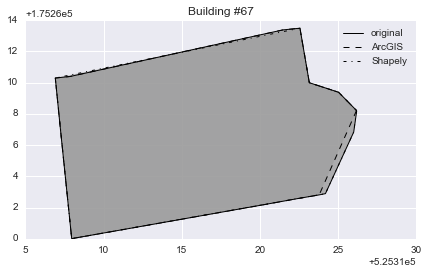

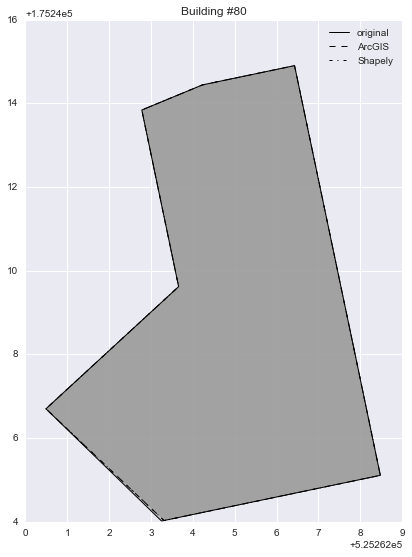

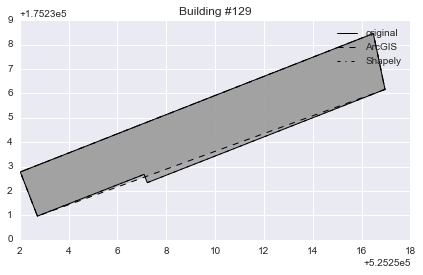

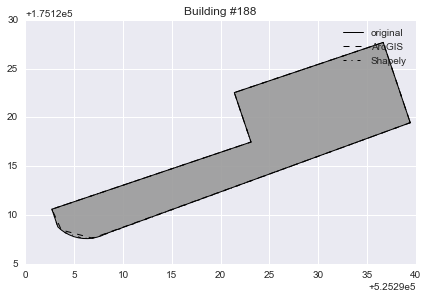

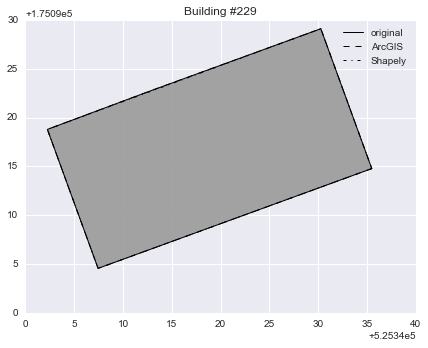

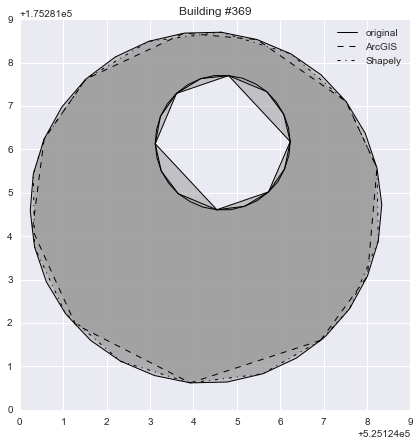

In [48]:
for i in Test_buildings_2:
    plot_building(i, test_tol)

Figures 2.1.1 Plots of Raw/GP/ArcGIS test buildings 6, 55, 60, 67, 80, 129, 188, 229, 369

In [49]:
analyse_test_buildings_2 = []
for number in Test_buildings_2:
    analyse_test_buildings_2 = compare_values(number, analyse_test_buildings_2, test_tol, answer='n')

In [50]:
analyse_test_buildings_2

,Raw Area,GP Area,ArcGIS Area,Raw Vertices,GP Vertices,ArcGIS Vertices
6,20.41170,20.40755,20.40755,9.0,8.0,8.0
55,7.53255,7.31120,5.98145,31.0,15.0,7.0
60,34.10760,34.35150,35.27905,13.0,9.0,7.0
67,182.53500,182.27960,180.64580,18.0,9.0,15.0
80,50.17840,50.08750,50.08420,11.0,9.0,10.0
129,33.71895,33.69025,32.64990,9.0,7.0,7.0
188,226.12025,226.39990,224.80830,22.0,10.0,11.0
229,454.21175,453.34345,454.21325,9.0,5.0,8.0
369,43.62765,42.81900,42.27965,34.0,17.0,12.0


Table 2.1.2 Raw/GP/ArcGIS Areas and Vertices for each of test buildings 2

As can be seen above, GP altered buildings conformed much more closely to the shape of the buildings than ArcGIS. This is especially obvious when it comes to the curves, in which GP keeps more vertices than ArcGIS.

While GP cut less vertices than ArcGIS for some shapes, especially any with curves, GP was very good at getting rid of unimportant/visually unnoticeable vertices (buildings 67, 80 and 229). 

It can also be inferred that GP cuts out more of these visually unnoticeable vertices for many more of the 201 Polygons it alters. This is because, despite having a low relatively low tolerance, it still reduces the number of vertices in Raw buildings by 460 (Table 1.3.4), almost double that reduced by ArcGIS - 236 (Reference 2)

# Section 2 Conclusion:

Using the lower tolerance, ie around 0.12, will achieve our purpose of significantly simplifying the polygons with minimal effects on both the Area and the wall's orientation. 

# Section 3: Random Testing with chosen Tolerance (=0.12)

This section will be dedicated to ensuring that the chosen tolerance of 0.12 performs as expected on randomly selected buildings. The purpose of using randomly selected buildings is to ensure that no bias was unintentionally introduced during the above analysis where minimising area difference was a priority.

# Section 3.1

In [51]:
chosen_tolerance = 0.12

In [52]:
changed_buildings = [i for i,j in enumerate(compare(chosen_tolerance)['Either']) if j==True]

In [53]:
#Random selection of buildings. 
# I've chosen the random seed to be today's date, 04/08/16.

import random
random.seed(40816)

random_building = []
for x in range(12):
    num = random.choice(changed_buildings)
    random_building.append(num)
random_building.sort()

In [54]:
random_building

[12, 66, 72, 107, 125, 128, 129, 148, 163, 193, 219, 329]

List of random buildings chosen from a list of ALL buildings changed by either ArcGIS or Geopandas

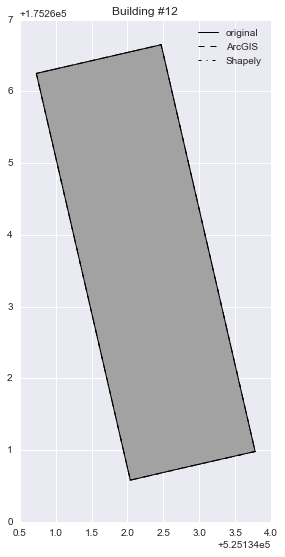

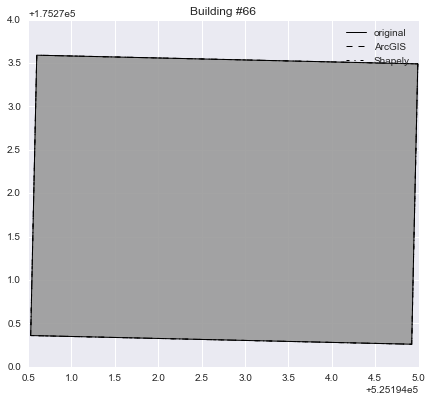

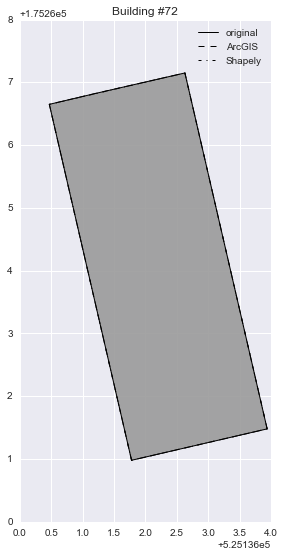

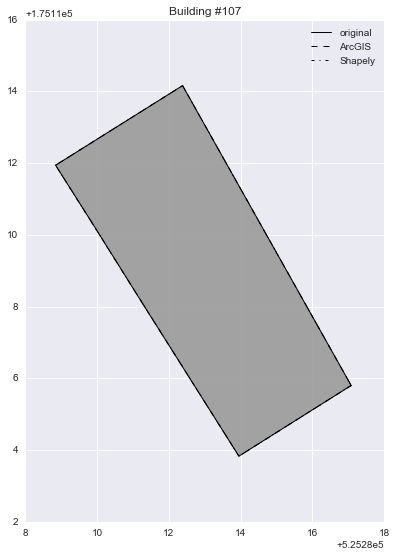

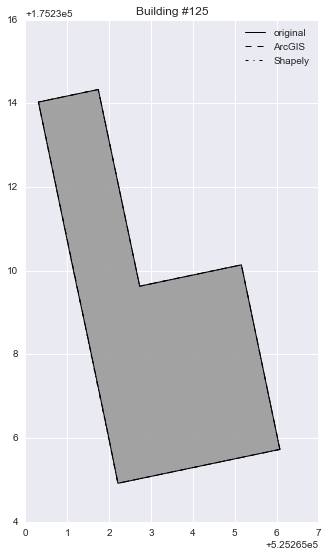

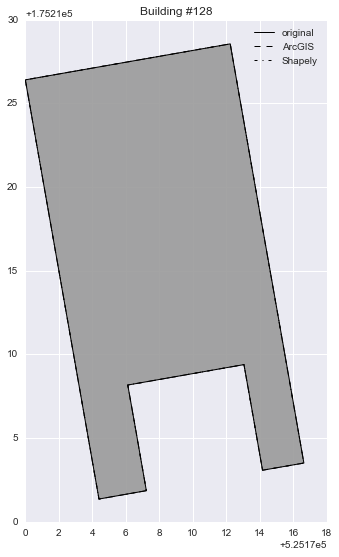

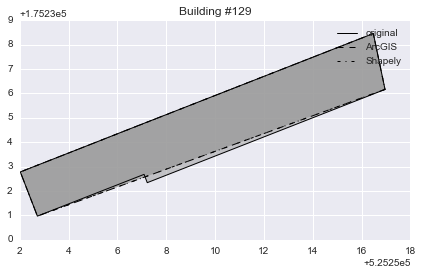

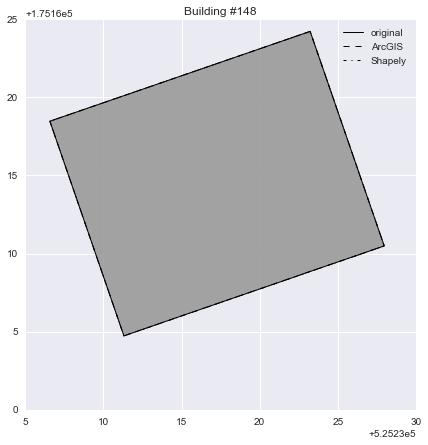

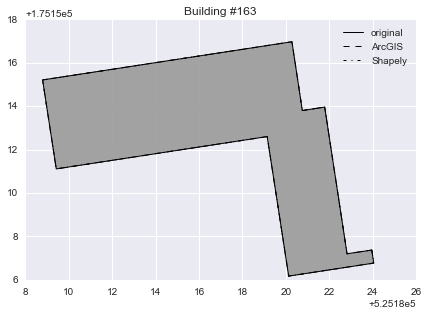

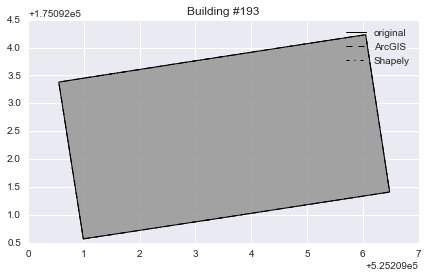

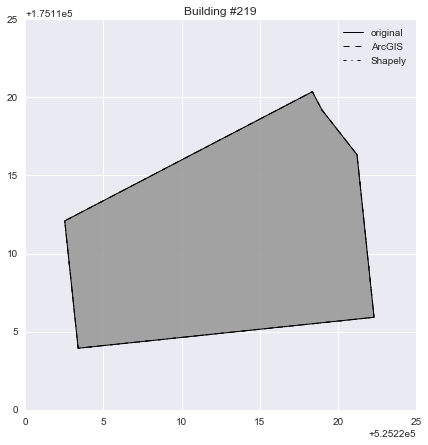

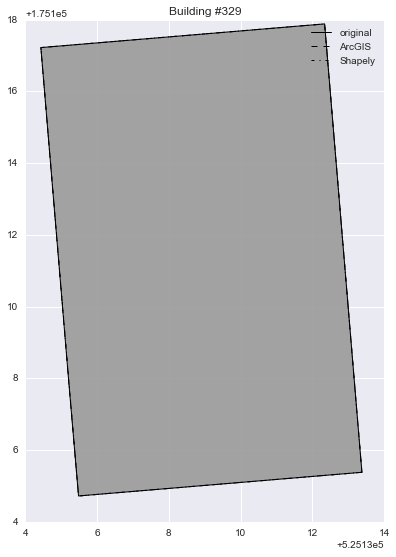

In [55]:
for i in random_building:
    plot_building(i)

Figures 3.1.1 Raw/ArcGIS/GP plots of each building in the random_building list [12, 66, 72, 107, 125, 128, 129, 148, 163, 193, 219, 329]

In [56]:
compare_test_buildings = []
for number in random_building:
    compare_test_buildings = compare_values(number, compare_test_buildings, answer='n')

In [57]:
compare_test_buildings

,Raw Area,GP Area,ArcGIS Area,Raw Vertices,GP Vertices,ArcGIS Vertices
12,10.38720,10.38980,10.38720,6.0,5.0,6.0
66,14.18540,14.18670,14.18540,6.0,5.0,6.0
72,12.90580,12.90220,12.90580,6.0,5.0,6.0
107,37.74065,37.73970,37.74065,7.0,5.0,7.0
125,24.82955,24.84810,24.80840,10.0,7.0,9.0
128,270.79555,270.73565,270.73565,15.0,10.0,12.0
129,33.71895,32.62120,32.64990,9.0,5.0,7.0
148,256.10000,256.14200,256.09660,10.0,6.0,7.0
163,68.21320,68.21895,68.21320,12.0,11.0,12.0
193,15.85470,15.84350,15.85470,8.0,6.0,8.0


Table 3.1.1 Raw/GP/ArcGIS Areas and Vertices for each of random_building

As can be seen from figures 3.1.1 and Table 3.1.1, Geopandas has managed many times to reduce the number of vertices while very minimally affecting the area, both visually and in real numerical terms.

In [58]:
p = compare_test_buildings['Raw Area'].sum()-compare_test_buildings['GP Area'].sum()
q = compare_test_buildings['Raw Area'].sum()-compare_test_buildings['ArcGIS Area'].sum()

r = compare_test_buildings['Raw Vertices'].sum() - compare_test_buildings['GP Vertices'].sum()
s = compare_test_buildings['Raw Vertices'].sum() - compare_test_buildings['ArcGIS Vertices'].sum()

print(p, q, r, s, sep='\n')

1.13230001014
1.15350001447
26.0
9.0


The above results may be a little misleading as it included many examples of buildings which GP changed but that was untouched by ArcGIS

Thus, let us pick random buildings from the range of buildings that were affected by both GP and ArcGIS

# Section 3.2

In [59]:
chosen_tolerance = 0.12
changed_buildings_2 = [i for i,j in enumerate(compare(chosen_tolerance)['Both']) if j==True]

In [60]:
#Tested on 06/08/16
random.seed(60816)

random_building_2 = []
for x in range(12):
    while len(random_building_2)<=x:
        num = random.choice(changed_buildings_2)
        if num not in random_building_2:
            random_building_2.append(num)
            
random_building_2.sort()

In [61]:
random_building_2

[8, 79, 94, 129, 150, 167, 188, 217, 275, 312, 350, 357]

List of random buildings chosen from a list of buildings changed by BOTH ArcGIS AND Geopandas

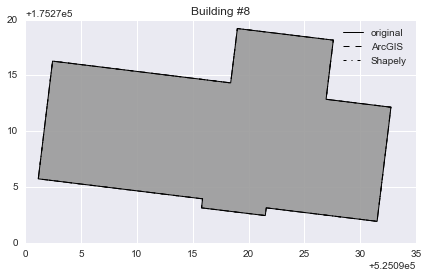

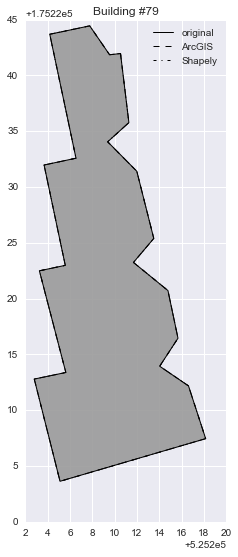

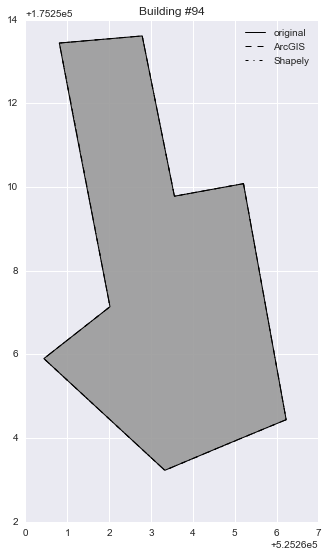

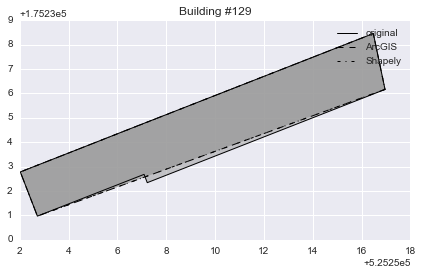

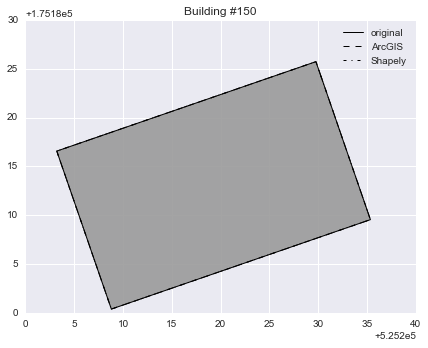

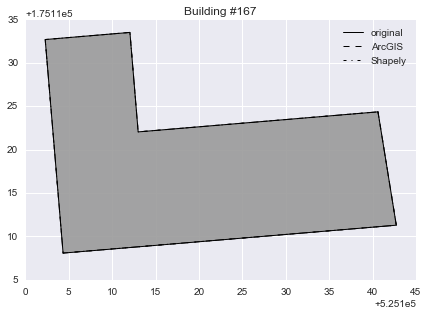

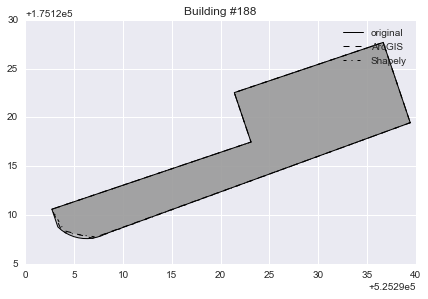

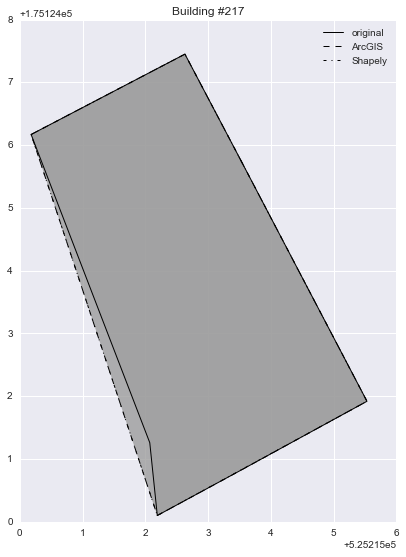

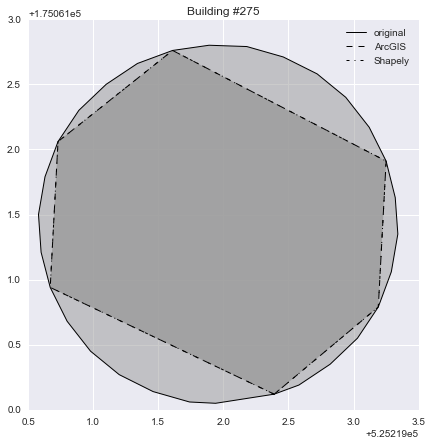

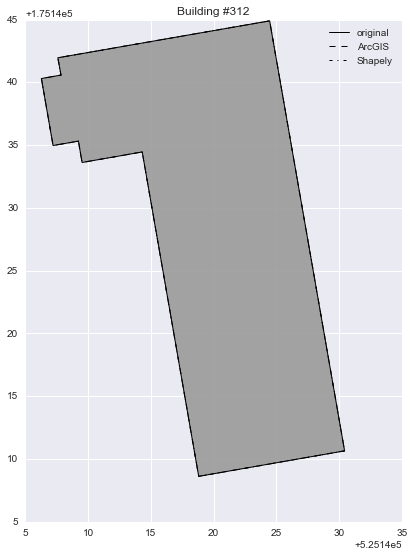

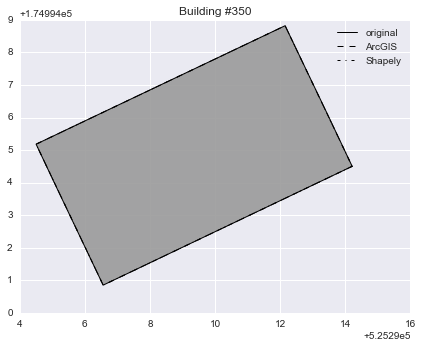

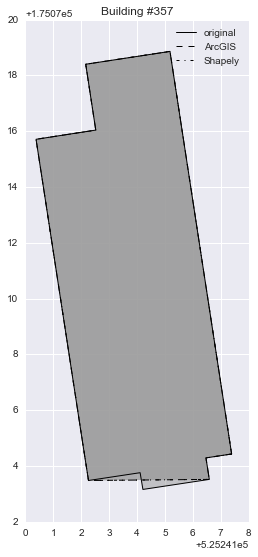

In [62]:
plots={}
for number in random_building_2:
    plots[number]=plot_building(number)

Figures 3.2.1 Raw/ArcGIS/GP plots of each building in the random_building_2 list [8, 79, 94, 129, 150, 167, 188, 217, 275, 312, 350, 357]

In [63]:
compare_test_buildings_2 = []
for number in random_building_2:
    compare_test_buildings_2 = compare_values(number, compare_test_buildings_2, answer='n')

In [64]:
compare_test_buildings_2

,Raw Area,GP Area,ArcGIS Area,Raw Vertices,GP Vertices,ArcGIS Vertices
8,370.83745,370.81755,370.84545,20.0,14.0,19.0
79,337.82565,337.80670,337.82515,26.0,22.0,25.0
94,33.12625,33.11070,33.10345,11.0,9.0,10.0
129,33.71895,32.62120,32.64990,9.0,5.0,7.0
150,480.49500,480.49160,480.47530,11.0,6.0,9.0
167,614.19200,614.02800,614.02800,9.0,7.0,7.0
188,226.12025,225.34220,224.80830,22.0,8.0,11.0
217,19.81005,20.60525,20.61165,8.0,6.0,7.0
275,5.93530,4.68360,4.68360,31.0,7.0,7.0
312,463.33595,463.31970,463.32935,15.0,11.0,14.0


Table 3.2.1 Raw/GP/ArcGIS Areas and Vertices for each of random_building_2

In [65]:
p = compare_test_buildings_2['Raw Area'].sum()-compare_test_buildings_2['GP Area'].sum()
q = compare_test_buildings_2['Raw Area'].sum()-compare_test_buildings_2['ArcGIS Area'].sum()

r = compare_test_buildings_2['Raw Vertices'].sum() - compare_test_buildings_2['GP Vertices'].sum()
s = compare_test_buildings_2['Raw Vertices'].sum() - compare_test_buildings_2['ArcGIS Vertices'].sum()

print(p, q, r, s, sep='\n')

2.77480000667
3.22609999725
73.0
51.0


Similar to the results above, GP with tolerance=0.12 manages to significantly reduce the number of vertices while managing to reduce less area than ArcGIS does.

It is interesting to note that, in this case, GP(0.12) had the exact same geometry as ArcGIS for building 275, which is almost completely circular.

GP(0.12) also very closely copied ArcGIS for Building 357. It is not certain how this will affect neighbouring walls, and if so, how does ArcGIS differentiate between whether it can cut the walls as it does when there are no neighbouring walls, or when it has to leave the shapes as they are when there are neighbouring walls. This may need to be explored further.

# Section 3 Conclusion

For the purpose of simplifying Polygons and removing as many unimportant or visually unnoticeable vertices from polygons, while minimising the change in area of the polygons from their raw shape, Geopandas' Simplify function at tolerance=0.12 does a noticeably better job than ArcGIS' arcpy.SimplifyPolygon_cartography function. 

During times when Geopandas' Simplify function does also cause drastic changes to the number of vertices eg Building 275, the change is not bigger/the same as the change caused by ArcGIS, which Geopandas' Simplify function (tolerance=0.12) a suitable candidate for replacing ArcGIS.

# Report Summary and Conclusion:

1. From Secion 1, it is impossible to control the tolerance for Geopandas' Simplify function to closely immitate the ArcGIS arcpy.SimplifyPolygon_cartography function. Thus, another approach was considered ie to copy the original purpose of simplifying polygons by reducing non-essential vertices while keeping area similar and without altering wall orientation too drastically.

2. 2 possible tolerance values were found: one to immitate ArcGIS as closely as possible (tolerance = 0.4 which gives the smallest absolute area difference between Geopandas and ArcGIS), and one that had a good compromise between following ArcGIS geometry while minimising area differences (tolerance = 0.12 which gives the smallest change in area while changing all but one building that ArcGIS changes)

3. In Section 2, it was determined that tolerance=0.4 would not work. Visually, it gave some significantly different polygons from both ArcGIS and the Raw buildings.

4. Tolerance=0.12 gave reasonably similar altered polygons to most of the Raw buildings. It was also better at getting rid of visually insignificant vertices while reducing less area than ArcGIS.

5. The result of 4. was further tested and confirmed using various random buildings in Section 3

6. Further testing on neighbouring buildings may need to be done to completely approve the use of Geopandas' Simplify function at tolerance=0.12 to replace ArcGIS.